In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
class ImageLoader:
    def __init__(self):
        self.num_images = 0
        self.images = None
        self.labels = None
        self.mnist = fetch_openml('mnist_784', version=1)

    def load_data(self, num_images=5000):
        self.num_images = num_images
        mnist = self.mnist
        X, y = mnist['data'], mnist['target'].astype(int)
        X_array = X.values  # Convert DataFrame to NumPy array
        self.images = X_array[:self.num_images].reshape(self.num_images, 28, 28)  # Reshape images to 2D
        self.labels = y[:self.num_images]  # Get the corresponding labels

In [4]:
class ConvLayer:
    def __init__(self, num_filters, filter_size=3):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.01
        self.filter_grads = np.zeros_like(self.filters)  # To store gradients
        self.output_height = None
        self.output_width = None

    def conv2d(self, input_data):
        num_filters, filter_size = self.num_filters, self.filter_size
        num_input_filters, height, width = input_data.shape
        self.output_height = max(0, height - filter_size + 1)  # Save output dimensions
        self.output_width = max(0, width - filter_size + 1)
        output = np.zeros((num_filters, self.output_height, self.output_width))

        for f in range(num_filters):
            filter = self.filters[f]
            for i in range(self.output_height):
                for j in range(self.output_width):
                    region = input_data[:, i:i+filter_size, j:j+filter_size]
                    output[f, i, j] = np.sum(region * filter)

        return output

    def max_pooling(self, feature_maps, pool_size=2, stride=2):
        num_filters, height, width = feature_maps.shape
        self.output_height = (height - pool_size) // stride + 1  # Save output dimensions
        self.output_width = (width - pool_size) // stride + 1
        output = np.zeros((num_filters, self.output_height, self.output_width))

        for f in range(num_filters):
            for i in range(0, self.output_height * stride, stride):
                for j in range(0, self.output_width * stride, stride):
                    if i + pool_size <= height and j + pool_size <= width:
                        region = feature_maps[f, i:i+pool_size, j:j+pool_size]
                        output[f, i//stride, j//stride] = np.max(region)

        return output

    def update_filters(self, learning_rate=0.01):
        self.filters -= learning_rate * self.filter_grads
        self.filter_grads = np.zeros_like(self.filters)  # Reset gradients

    def compute_gradients(self, input_data, grad_output):
        self.filter_grads = np.zeros_like(self.filters)
        filter_size = self.filters.shape[1]  # Get filter size from the current layer

        for f in range(self.num_filters):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    # Ensure input_data slice matches the number of filters in the previous layer
                    self.filter_grads[f] += np.sum(input_data[:, i:i+filter_size, j:j+filter_size] * grad_output[f, i, j], axis=0)

        # print("Filter Gradients:", self.filter_grads)  # Print the calculated filter gradients
        return self.filter_grads


    def backward(self, input_data, grad_output):
        num_input_filters, height, width = input_data.shape
        num_filters, filter_size = self.num_filters, self.filter_size
        d_input = np.zeros_like(input_data)  # Gradient with respect to input data
        self.filter_grads = np.zeros_like(self.filters)  # Reset filter gradients

        # print("Input Data Shape:", input_data.shape)
        # print("Gradient Output Shape:", grad_output.shape)
        # print("Filter Shape:", self.filters.shape)

        # Calculate gradients with respect to filters
        for f in range(num_filters):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    region = input_data[:, i:i+filter_size, j:j+filter_size]
                    self.filter_grads[f] += np.sum(
                        region * grad_output[f, i, j], axis=0
                    )

                    # # Debug messages for filter gradients
                    # print(f"Filter Grad {f} Shape:", self.filter_grads[f].shape)
                    # print(f"Region Shape: {region.shape}")
                    # print(f"Grad Output [{f}, {i}, {j}] Shape: {grad_output[f, i, j].shape}")

        # Calculate gradients with respect to input data
        for f in range(num_filters):
            for i in range(self.output_height):
                # print(f"Filter {f} Shape:", self.filters[f].shape)
                for j in range(self.output_width):
                    region = input_data[:, i:i+filter_size, j:j+filter_size]
                    d_input[:, i:i+filter_size, j:j+filter_size] += self.filters[f] * grad_output[f, i, j]

        #             print(f"Grad Output [{f}, {i}, {j}] Shape: {grad_output[f, i, j].shape}")
        #             print(f"d_input Region Shape: {d_input[:, i:i+filter_size, j:j+filter_size].shape}")

        # print("Computed Gradients with Respect to Input:", d_input)
        return d_input

In [5]:
import matplotlib.pyplot as plt

def display_images(original_image, first_layer_output, second_layer_output):
    # Calculate number of rows for subplots based on number of filters
    num_rows_first = first_layer_output.shape[0] // 2 + (first_layer_output.shape[0] % 2)
    num_rows_second = second_layer_output.shape[0] // 3 + (second_layer_output.shape[0] % 3)

    # Create a figure with enough subplots
    fig = plt.figure(figsize=(15, 5 + 3 * (num_rows_first + num_rows_second)))

    # Original Image
    plt.subplot(num_rows_first + num_rows_second + 1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # First Layer Outputs
    for i in range(first_layer_output.shape[0]):
        plt.subplot(num_rows_first + num_rows_second + 1, 3, 3 + i + 1)
        plt.imshow(first_layer_output[i], cmap='gray')
        plt.title(f'First Layer Filter {i+1}')
        plt.axis('off')

    # Second Layer Outputs
    for i in range(second_layer_output.shape[0]):
        plt.subplot(num_rows_first + num_rows_second + 1, 3, 3 + first_layer_output.shape[0] + i + 1)
        plt.imshow(second_layer_output[i], cmap='gray')
        plt.title(f'Second Layer Filter {i+1}')
        plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

In [6]:
loader = ImageLoader()

In [7]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, predictions, targets):
        m = targets.shape[0]
        log_likelihood = -np.log(predictions[range(m), targets])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, predictions, targets):
        m = x.shape[0]  # Number of samples

        # Gradient of the loss with respect to the output of the final layer
        d_z2 = predictions
        d_z2[range(m), targets] -= 1
        d_z2 /= m

        # Gradients for weights and biases of the final layer
        d_W2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis=0, keepdims=True)

        # Gradient with respect to activations of the first layer
        d_a1 = np.dot(d_z2, self.W2.T)
        d_z1 = d_a1 * (self.a1 > 0)  # ReLU derivative

        # Gradients for weights and biases of the first layer
        d_W1 = np.dot(x.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)

        # Update weights and biases
        self.W1 -= 0.01 * d_W1
        self.b1 -= 0.01 * d_b1
        self.W2 -= 0.01 * d_W2
        self.b2 -= 0.01 * d_b2

        # Return gradient with respect to the input
        return np.dot(d_z1, self.W1.T)



In [8]:
loader.load_data(num_images=10000)


In [9]:
conv1 = ConvLayer(num_filters=4)
conv2 = ConvLayer(num_filters=9)

X_images_train, X_images_test, y_train, y_test = train_test_split(loader.images, loader.labels, test_size=0.1, random_state=42)

In [10]:
input_size = 225
hidden_size = 128
# Calculate the number of unique classes in the training labels
output_size = 10

nn = SimpleNN(input_size, hidden_size, output_size)

In [15]:
import matplotlib.pyplot as plt

def train_nn_with_conv(nn, X_images_train, y_train, epochs=10, learning_rate=0.01):
    # Prepare the transformed training data
    X_train_transformed = []
    for original_image in X_images_train:
        # Apply first convolution and pooling layer
        first_layer_output = conv1.conv2d(original_image[np.newaxis, :, :])
        first_layer_output = conv1.max_pooling(first_layer_output)

        # Apply second convolution and pooling layer
        second_layer_output = conv2.conv2d(first_layer_output)
        second_layer_output = conv2.max_pooling(second_layer_output)

        # Flatten the output and store it
        X_train_transformed.append(second_layer_output.flatten())
    X_train_transformed = np.array(X_train_transformed)
    y_train = np.array(y_train)

    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        # Training loop
        for i in range(len(X_train_transformed)):

            flattened_output = X_train_transformed[i]
            label = y_train[i]

            # Forward pass
            predictions = nn.forward(flattened_output[np.newaxis, :])

            # Compute loss and gradients
            loss = nn.compute_loss(predictions, np.array([label]))
            d_flattened_output = nn.backward(flattened_output[np.newaxis, :], predictions, np.array([label]))

            total_loss += loss

        average_loss = total_loss / len(X_train_transformed)
        loss_history.append(average_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss}')

    # Plotting the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# train_nn_with_conv(nn, X_images_train, y_train, epochs=10, learning_rate=0.01)


Epoch 1/10, Loss: 0.3463918535482198
Epoch 2/10, Loss: 0.32884609205985704
Epoch 3/10, Loss: 0.31258941230948945
Epoch 4/10, Loss: 0.29757129504579033
Epoch 5/10, Loss: 0.2838362995017432
Epoch 6/10, Loss: 0.27084848897308217
Epoch 7/10, Loss: 0.2587433444940087
Epoch 8/10, Loss: 0.2472961297116228
Epoch 9/10, Loss: 0.23650450144115304
Epoch 10/10, Loss: 0.22635735395765372


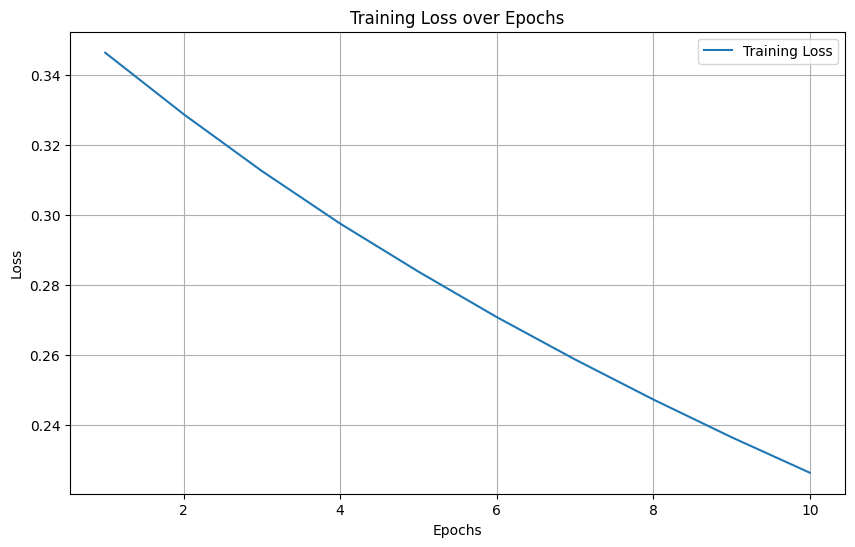

In [16]:
train_nn_with_conv(nn, X_images_train, y_train, epochs=10, learning_rate=0.01)

In [13]:
def test_nn(nn, X_test, y_test):
    X_test_transformed = []
    y_test = np.array(y_test)

    for original_image in X_test:
        # Apply first convolution and pooling layer
        first_layer_output = conv1.conv2d(original_image[np.newaxis, :, :])
        first_layer_output = conv1.max_pooling(first_layer_output)

        # Apply second convolution and pooling layer
        second_layer_output = conv2.conv2d(first_layer_output)
        second_layer_output = conv2.max_pooling(second_layer_output)

        # Flatten the output and store it
        X_test_transformed.append(second_layer_output.flatten())

    X_test_transformed = np.array(X_test_transformed)
    correct_predictions = 0
    total_samples = len(X_test)

    y_pred = []

    for i in range(total_samples):
        x = X_test_transformed[i]
        # Forward pass
        predictions = nn.forward(x[np.newaxis, :])

        # Convert predictions to class labels
        predicted_class = np.argmax(predictions)
        y_pred.append(predicted_class)

    report = classification_report(y_test, y_pred, digits=4)
    print("Classification Report:\n", report)

In [17]:
test_nn(nn, X_images_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0     0.9266    0.9712    0.9484       104
           1     0.9722    0.9722    0.9722       108
           2     0.8763    0.9043    0.8901        94
           3     0.8485    0.8400    0.8442       100
           4     0.9368    0.8812    0.9082       101
           5     0.8587    0.8316    0.8449        95
           6     0.9818    0.9391    0.9600       115
           7     0.8909    0.9515    0.9202       103
           8     0.8642    0.8537    0.8589        82
           9     0.8687    0.8776    0.8731        98

    accuracy                         0.9050      1000
   macro avg     0.9025    0.9022    0.9020      1000
weighted avg     0.9055    0.9050    0.9049      1000

